# Names Transition Modeling

In [1]:
import pandas as pd 
import unicodedata 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import re 
import sys 
import os 

sys.path.append(os.path.abspath("..")) 
from collections import Counter 
from core.utils.data_loader import DataLoader 
from core.config.pipeline_config import PipelineConfig

In [2]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints"
    }
)

loader = DataLoader(config)

def normalize_letters(s):
    """Normalize accents -> ascii, lowercase, keep only a-z."""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = s.encode("ascii", errors="ignore").decode("utf-8")
    s = s.lower()
    s = re.sub(r"[^a-z]", "", s)
    return s

In [17]:
df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")

def clean_province(s):
    return (
        s.str.upper()
        .str.strip()
        .apply(lambda x: unicodedata.normalize("NFKD", x)
               .encode("ascii", errors="ignore")
               .decode("utf-8") if isinstance(x, str) else x)
    )
df['province'] = clean_province(df['province'])

df_simple = df[df['identified_category'] == 'simple'].copy()
df_simple['surname'] = df_simple['identified_name'].str.split().str[0]
df_simple['middle_name'] = df_simple['identified_name'].str.split().str[1]
df_simple['first_name'] = df_simple['identified_surname']
df_simple = df_simple[df_simple['first_name'].notna() & (df_simple['first_name'].str.strip() != '')]

In [7]:
display(df['province'].value_counts().reset_index().head(12))

,province,count
0,KINSHASA,1140620
1,AUTRES,1035751
2,KATANGA,836220
3,BANDUNDU,809949
4,KASAI-ORIENTAL,434497
5,NORD-KIVU,394999
6,KASAI-OCCIDENTAL,367626
7,EQUATEUR,356404
8,SUD-KIVU,346152
9,ORIENTALE,322756


# Surname (for whole country)

In [8]:
surnames = df_simple['surname'].astype(str).str.lower().tolist()
surnames = [re.sub(r"[^a-z]", "", name) for name in surnames] 
sequences = ['^' + s + '$' for s in surnames if s]

tokens = ['^'] + list('abcdefghijklmnopqrstuvwxyz') + ['$']
index = {t: i for i, t in enumerate(tokens)}

In [9]:
transitions = Counter()
for seq in sequences:
    for a, b in zip(seq, seq[1:]):
        if a in index and b in index:
            transitions[(a, b)] += 1

matrix = np.zeros((len(tokens), len(tokens)), dtype=int)
for (a, b), count in transitions.items():
    matrix[index[a], index[b]] += count

df_counts = pd.DataFrame(matrix, index=tokens, columns=tokens)
df_probs = df_counts.div(df_counts.sum(axis=1).replace(0, 1), axis=0)    

## Transition matrix for the entire country

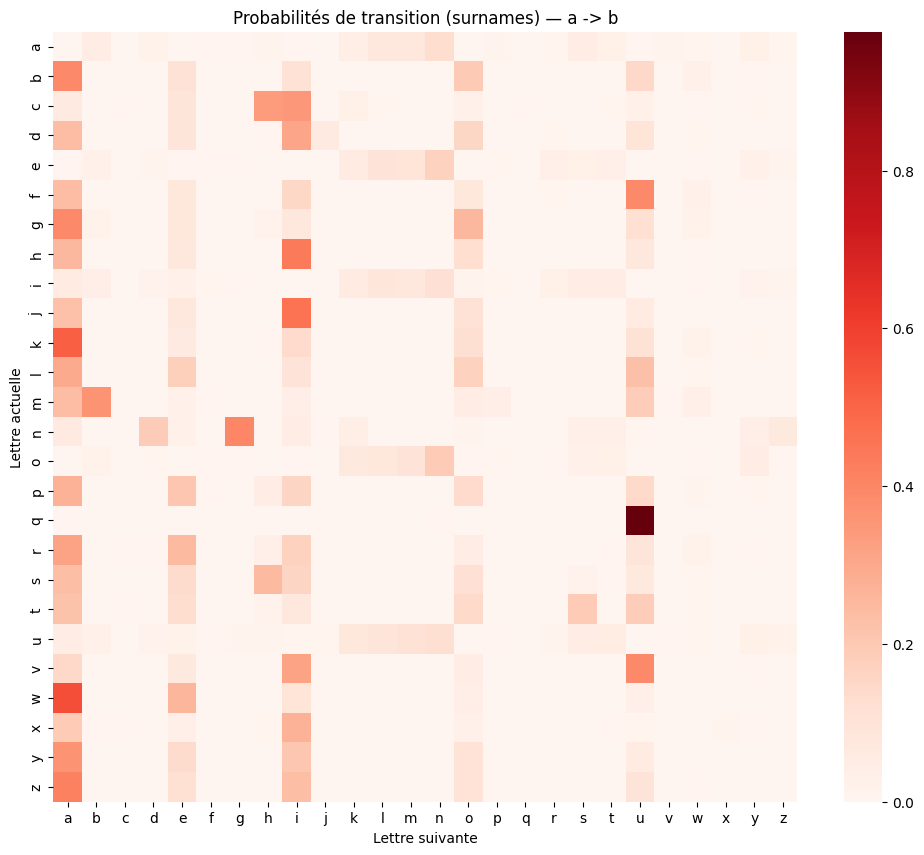

In [10]:
letters = list('abcdefghijklmnopqrstuvwxyz')
plt.figure(figsize=(12, 10))
sns.heatmap(df_probs.loc[letters, letters].values,
            xticklabels=letters, yticklabels=letters,
            cmap="Reds")
plt.title("Transition probabilities (surnames)  — a -> b")
plt.xlabel("Next letter")
plt.ylabel("Current letter")
plt.show()

In [12]:
def generate_name(prob_matrix, index, tokens, max_len=12):
    inv_index = {i: l for l, i in index.items()}
    
    current = '^' 
    result = []
    
    for _ in range(max_len):
        row = prob_matrix[index[current]]
        next_letter = np.random.choice(tokens, p=row)
        
        if next_letter == '$': 
            break
        result.append(next_letter)
        current = next_letter
    
    return "".join(result).capitalize()

generated_names = [generate_name(df_probs.values, index, tokens) for _ in range(10)]
generated_names

['Mwa',
 'Amba',
 'Mbuloka',
 'Muki',
 'Zasa',
 'Ndomwandileg',
 'Emashianzolo',
 'Ma',
 'Lizimafu',
 'Tsulangesony']